<img style="float:left" width="70%" src="../../documentacion/imagenes/escudo_COLOR_1L_DCHA.png">
<img style="float:right" width="10%" src="../../documentacion/imagenes/PythonLogo.svg">
<br style="clear:both;">


<h2 style="display: inline-block; padding: 4mm; padding-left: 2em; background-color: navy; line-height: 1.3em; color: white; border-radius: 10px;">8. Deep Learning LSTM</h2>


 
## Estudiante:

- Jose Luis Perez Gomez

In [24]:
%run 3.Importaciones.ipynb
%run 4.Variables_Clases.ipynb

In [25]:
experimento_1_nor_separado = pd.read_csv('../datos/experimento_stscaler_separado1.csv', sep=',')
experimento_2_nor_separado = pd.read_csv('../datos/experimento_stscaler_separado2.csv', sep=',')
experimento_3_nor_separado = pd.read_csv('../datos/experimento_stscaler_separado3.csv', sep=',')
experimento_4_nor_separado = pd.read_csv('../datos/experimento_stscaler_separado4.csv', sep=',')
experimento_all_nor = pd.read_csv('../datos/experimento_stscaler_all.csv', sep=',')
experimento_all_nor_separado = pd.read_csv('../datos/experimento_stscaler_separado_all.csv', sep=',')

experimento_1_nor_separado = experimento_1_nor_separado.drop(['Timestamp'], axis=1)
experimento_2_nor_separado = experimento_2_nor_separado.drop(['Timestamp'], axis=1)
experimento_3_nor_separado = experimento_3_nor_separado.drop(['Timestamp'], axis=1)
experimento_4_nor_separado = experimento_4_nor_separado.drop(['Timestamp'], axis=1)

experimentos_nor = [experimento_1_nor_separado, experimento_2_nor_separado, experimento_3_nor_separado, experimento_4_nor_separado, experimento_all_nor, experimento_all_nor_separado ]


# LSTM (Long short-term memory)

In [26]:
train_datos, val_datos, test_datos = dividir_datos_deep(experimento_all_nor_separado)

In [27]:
print(f'train_datos: {train_datos.shape}')
print(f'val_datos: {val_datos.shape}')
print(f'test_datos: {test_datos.shape}')

train_datos: (542, 11)
val_datos: (67, 11)
test_datos: (69, 11)


In [28]:
train_datos['Key'].value_counts()

Key
0.0    149
1.0    112
4.0    102
3.0     90
2.0     89
Name: count, dtype: int64

In [29]:
val_datos['Key'].value_counts()

Key
0.0    17
3.0    14
4.0    14
1.0    13
2.0     9
Name: count, dtype: int64

In [30]:
test_datos['Key'].value_counts()

Key
0.0    20
2.0    16
1.0    15
4.0    11
3.0     7
Name: count, dtype: int64

In [31]:

def preparar_ventanas(datos, target, window_size=WINDOWS_SIZE, overlap=OVERLAP, target_type=TARGET_TYPE):
    
    if window_size <= overlap:
        raise "Overlap no puede ser mayor que window_size"
    X = []
    y = []
    for i in range(0, len(datos) - window_size, window_size - overlap):
        X.append(datos[i:i+window_size])
        window_targets = target[i:i+window_size].astype(int)
        y_true = window_targets[-1]
        y.append(y_true)

    #y_one_hot = tf.keras.utils.to_categorical(np.array(y), num_classes = 5)
    # Key = [0, 1, 2, 3, 4, 0]
    # One-hot [
    #    [0, 1, 2, 3, 4]
    #     1  0  0  0  0
    #     0  1  0  0  0
    #     0  0  1  0  0
    #]
    #return np.array(X), y_one_hot
    return np.array(X), np.array(y)

In [32]:
#columns = train_datos.columns[train_datos.columns != TARGET]
columns = train_datos.columns[train_datos.columns]



IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [33]:
X_train, y_train = preparar_ventanas(train_datos.values, train_datos[TARGET].values, WINDOWS_SIZE, OVERLAP, TARGET_TYPE)
X_val, y_val = preparar_ventanas(val_datos.values, val_datos[TARGET].values, WINDOWS_SIZE, OVERLAP, TARGET_TYPE)
X_test, y_test = preparar_ventanas(test_datos.values, test_datos[TARGET].values, WINDOWS_SIZE, OVERLAP, TARGET_TYPE)

In [34]:
print(f'X_train: {X_train.shape}')
print(f'X_val: {X_val.shape}')
print(f'X_test: {X_test.shape}')
print(f'y_train: {y_train.shape}')
print(f'y_val: {y_val.shape}')
print(f'y_test: {y_test.shape}')

print(y_val)


X_train: (539, 3, 11)
X_val: (64, 3, 11)
X_test: (66, 3, 11)
y_train: (539,)
y_val: (64,)
y_test: (66,)
[2 2 2 2 2 2 2 0 0 0 0 0 3 3 3 3 3 3 3 3 3 3 3 3 3 3 0 0 0 0 0 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 4 4 4 4 4 4 4 4 4 4 4 4 4 4 0]


In [35]:
# Definición del modelo
timesteps = 30
features = 11

def crear_LSTM(input_size, num_classes):
    model_LSTM = Sequential()
    model_LSTM.add(LSTM(units=30, input_shape=(timesteps, features), return_sequences=False))
    model_LSTM.add(Dense(30))
    model_LSTM.add(Dense(num_classes, activation='softmax'))
                        
    return model_LSTM




In [36]:
num_classes = 5
input_size = X_train.shape[1:]
model_LSTM = crear_LSTM(input_size, num_classes)
model_LSTM.summary()


C:\Users\Casa\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                        │ (None, 30)                  │           5,040 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 30)                  │             930 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 5)                   │             155 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,125 (23.93 KB)

 Trainable params: 6,125 (23.93 KB)

 Non-trainable params: 0 (0.00 B)

In [37]:
checkpoint_filepath = 'checkpoint/mlp.keras'

# Crear checkpoint
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_loss',
    mode='min',
    save_best_only=True
)

# Hiperparámetros
batch_size = 30
learning_rate = 1e-0
epochs = 50
#dropout = 0.5
weight_decay = 1e-0



# Compilamos el modelo
optimizador = Adam(learning_rate=learning_rate)
#optimizador = AdamW(learning_rate=learning_rate, weight_decay=weight_decay)
model_LSTM.compile(optimizer= optimizador,
                  #loss='categorical_crossentropy',
                  loss='sparse_categorical_crossentropy',
                  metrics=["accuracy"])

# Entrenar
LSTM_output = model_LSTM.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=epochs, batch_size=batch_size,
    callbacks=[model_checkpoint_callback]
)

Epoch 1/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.2741 - loss: 52.1835 - val_accuracy: 0.3750 - val_loss: 36.5407
Epoch 2/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.3757 - loss: 27.3011 - val_accuracy: 0.3906 - val_loss: 12.5560
Epoch 3/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.3919 - loss: 11.7422 - val_accuracy: 0.4062 - val_loss: 8.6597
Epoch 4/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4109 - loss: 7.3828 - val_accuracy: 0.4219 - val_loss: 7.1021
Epoch 5/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4937 - loss: 6.0199 - val_accuracy: 0.3906 - val_loss: 4.7409
Epoch 6/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4480 - loss: 4.2527 - val_accuracy: 0.3281 - val_loss: 5.1259
Epoch 7/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4466 - loss: 2.9270 - val_accuracy: 0.3594 - val_loss: 3.2996
Epoch 8/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4751 - loss: 2.8962 - val_accuracy: 0.4062 - val

In [38]:
def learning_curve(history, key='loss', title='Loss curve'):
    epochs = np.arange(1, len(history.history[key]) + 1)

    plt.figure(figsize=(20, 4))
    plt.subplot(1, 3, 1)
    plt.plot(epochs, history.history[key], label='Training')
    plt.plot(epochs, history.history['val_' + key], label='Validation')
    plt.title(title)
    plt.xlabel('Epochs')
    plt.ylabel(key.title())
    plt.legend()

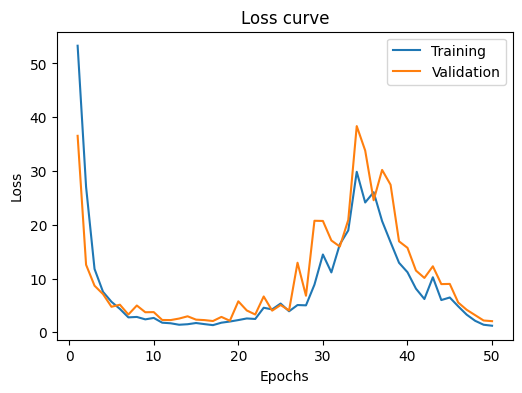

In [39]:
learning_curve(LSTM_output, 'loss')

In [40]:
# Cargar pesos del mejor modelo
model_LSTM.load_weights(checkpoint_filepath)

In [41]:
probabilidades_val = model_LSTM.predict(X_val)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step  


In [42]:
print(probabilidades_val)
y_val_pred = probabilidades_val.argmax(1)
print(y_val_pred)
print(y_val)
#etiquetas_val = y_val.argmax(1)
#print(etiquetas_val)

[[1.05375514e-35 5.09026868e-04 1.14363529e-01 4.22576249e-01
  4.62551236e-01]
 [1.03945656e-35 5.07182267e-04 1.14339128e-01 4.22675520e-01
  4.62478131e-01]
 [1.05375514e-35 5.09026868e-04 1.14363529e-01 4.22576249e-01
  4.62551236e-01]
 [1.05375514e-35 5.09026868e-04 1.14363529e-01 4.22576249e-01
  4.62551236e-01]
 [1.05375514e-35 5.09026868e-04 1.14363529e-01 4.22576249e-01
  4.62551236e-01]
 [9.93120033e-36 5.01071743e-04 1.14257932e-01 4.23006624e-01
  4.62234318e-01]
 [1.05375514e-35 5.09026868e-04 1.14363529e-01 4.22576249e-01
  4.62551236e-01]
 [9.99988317e-01 1.16960155e-05 1.25638512e-27 3.01683517e-33
  1.61243166e-33]
 [1.00000000e+00 2.37965555e-36 0.00000000e+00 0.00000000e+00
  0.00000000e+00]
 [1.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00]
 [1.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00]
 [1.00000000e+00 4.73850628e-29 0.00000000e+00 0.00000000e+00
  0.00000000e+00]
 [1.05375514e-35 5.09026868e-04 1.143635

In [43]:
#print(classification_report(etiquetas_val, y_val_pred, target_names=CLASES_KEY))
print(classification_report(y_val, y_val_pred, target_names=CLASES_KEY))

              precision    recall  f1-score   support

           0       0.84      1.00      0.91        16
           1       1.00      0.62      0.76        13
           2       0.00      0.00      0.00         7
           3       0.43      0.43      0.43        14
           4       0.30      0.50      0.38        14

    accuracy                           0.58        64
   macro avg       0.52      0.51      0.50        64
weighted avg       0.57      0.58      0.56        64



In [44]:
def visualizar_matriz_confusion(etiquetas_reales, etiquetas_predichas, class_names, titulo):
    # Calcular matriz de confusión
    cm = confusion_matrix(etiquetas_reales, etiquetas_predichas)

    # Visualizar matriz de confusión
    plt.figure(figsize=(7, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title(titulo)
    plt.xlabel('Predicción')
    plt.ylabel('Real')
    plt.show()

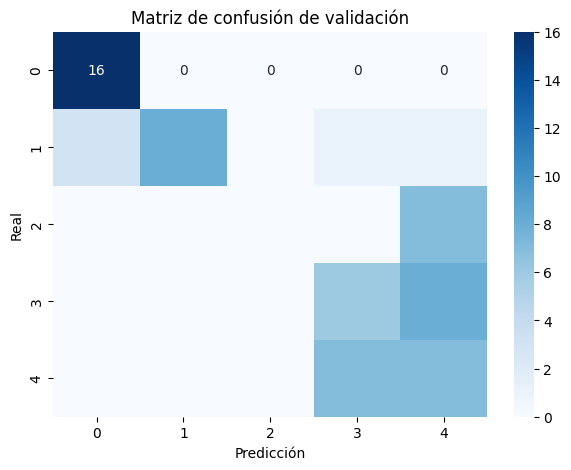

In [45]:
#visualizar_matriz_confusion(etiquetas_val, y_val_pred, CLASES_KEY, 'Matriz de confusión de validación')
visualizar_matriz_confusion(y_val, y_val_pred, CLASES_KEY, 'Matriz de confusión de validación')